# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.appName("Project3_ys").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [2]:
listings = spark.read.option('header', True).\
    option('inferSchema', True).\
    option('multiLine', True).\
    option('escape', "\"").csv('../data/listings.csv')

In [3]:
reviews = spark.read.option('header', True).\
    option('inferSchema', True).\
    option('multiLine', True).\
    option('escape', "\"").csv('../data/reviews.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

In [4]:
# Schema for listings.csv
listings.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [5]:
# size of listings.csv
print("The number of rows in listings.csv : {}".format(listings.count()))
print("The number of columns in listings.csv : {}".format(len(listings.columns)))

The number of rows in listings.csv : 1330480
The number of columns in listings.csv : 106


In [6]:
# Schema for reviews.csv
reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [7]:
# size of reviews.csv
print("The number of rows in reviews.csv : {}".format(reviews.count()))
print("The number of columns in reviews.csv : {}".format(len(reviews.columns)))

The number of rows in reviews.csv : 32297300
The number of columns in reviews.csv : 6


### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

In [8]:
# drop all NA values in listings and count the number of rows omitting those null values
listings_na=listings.dropna()
listings_na.count()

95

In [9]:
# listings_filtered = listings.filter(f.col('price').isNotNull())

In [10]:
# drop all NA values in reviews and count the number of rows omitting those null values
reviews_na = reviews.dropna()
reviews_na.count()

32284251

In [11]:
# We sampled 10% of the listings.csv and 5% of the reviews.csv
# We write them into local disk, listings_sample.csv and reviews_sample.csv

# No need to run now
# sample=df.sample(False, 0.05, 33)
# sample.coalesce(1).write.csv('data/names_here.csv')

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a table with the number of listings and neighbourhoods per city.

In [12]:
groupby_city=listings.groupBy('city').\
    agg(f.countDistinct('id').alias("Distinct Listings"),\
        f.countDistinct('neighbourhood_cleansed').alias("Distinct Neighbourhood")).cache()

In [13]:
groupby_city.show()

+--------------------+-----------------+----------------------+
|                city|Distinct Listings|Distinct Neighbourhood|
+--------------------+-----------------+----------------------+
|Saint-Médard-en-J...|              167|                     3|
|             Antwerp|              205|                    33|
|            Cadaqués|              463|                     1|
|               Lorne|              315|                     1|
|             Palermo|             9435|                    26|
|              Tuglie|              106|                     2|
|         Agia Galini|               66|                     1|
|        Thessaloniki|             2275|                     7|
|      Brunswick West|               86|                     3|
|              Sopela|               48|                     1|
|             Rødovre|               11|                     3|
|Paris-15E-Arrondi...|              100|                     1|
|           Aperregui|                1|

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [14]:
# Let's check if Copenhagen fulfills the requirement:

In [15]:
groupby_city.filter(f.col("city") == "Copenhagen").show()

+----------+-----------------+----------------------+
|      city|Distinct Listings|Distinct Neighbourhood|
+----------+-----------------+----------------------+
|Copenhagen|             2960|                    11|
+----------+-----------------+----------------------+



In [16]:
# Yup, it does. We will choose Copenhagen for further analysis.

In [17]:
# extract listings that are in Copenhagen
copenhagen=listings.filter(f.col("city") == "Copenhagen").cache()

In [18]:
# compute and show with a table the number of listings per neighbourhood per property type in Copenhagen.
copenhagen_groupby=copenhagen.groupBy('neighbourhood_cleansed','property_type').\
                    agg(f.countDistinct('id').alias("Listings Count")).\
                    orderBy('neighbourhood_cleansed', ascending=True)

In [19]:
copenhagen_groupby.show()

+----------------------+------------------+--------------+
|neighbourhood_cleansed|     property_type|Listings Count|
+----------------------+------------------+--------------+
|           Amager Vest|             House|            32|
|           Amager Vest|         Apartment|           172|
|           Amager Vest| Bed and breakfast|             1|
|           Amager Vest|Serviced apartment|            34|
|           Amager Vest|              Boat|             2|
|           Amager Vest|         Townhouse|            10|
|           Amager Vest|             Villa|             1|
|           Amager Vest|       Condominium|            16|
|           Amager Vest|              Loft|             3|
|             Amager st|              Loft|             3|
|             Amager st|             Villa|             3|
|             Amager st|Serviced apartment|            16|
|             Amager st|          Bungalow|             1|
|             Amager st|             House|            3

## Prices
Compute the minimum, maximum and average listing price in your city. 

In [20]:
# from the schema, it can be seen that the price column is of type string 
# using regular expression, we clean the strings and then cast the column type to float
copenhagen_cleanPrice = copenhagen.\
        withColumn('price', f.regexp_replace('price', '\$', '')).\
        withColumn('price', f.regexp_replace('price', ',', '')).\
        withColumn('price', f.col('price').cast('float'))

In [21]:
# compute the minimum, maximum and average listing price in Copenhagen
copenhagen_cleanPrice.select(f.min('price'), f.max('price'), f.avg('price')).show()

+----------+----------+-----------------+
|min(price)|max(price)|       avg(price)|
+----------+----------+-----------------+
|      68.0|   55556.0|922.2381756756756|
+----------+----------+-----------------+



Compute and visualize the distribution of listing prices in your city.

In [22]:
# use groupby, count the number of listings at each price
price_distribution = copenhagen_cleanPrice.groupby("price").\
                        agg(f.countDistinct('id').alias("count"))

In [23]:
price_distribution.show()

+-------+-----+
|  price|count|
+-------+-----+
| 1331.0|    1|
|  362.0|    8|
|  955.0|    3|
|   82.0|    1|
|  697.0|   12|
|  798.0|  118|
| 2054.0|    1|
|  969.0|   22|
| 1863.0|    1|
| 1283.0|    1|
| 3603.0|    1|
|  546.0|   15|
| 2177.0|    1|
| 1802.0|   18|
| 2293.0|    1|
|  239.0|    2|
| 1496.0|    1|
|55556.0|    1|
| 1378.0|    8|
|  301.0|    8|
+-------+-----+
only showing top 20 rows



In [24]:
# create a price list for histogram
price_list=[]
for row in price_distribution.collect():
    price_list.extend([row['price']] * int(row['count']))

Visualize price distribution using histogram. Adjust the bins and bin size:

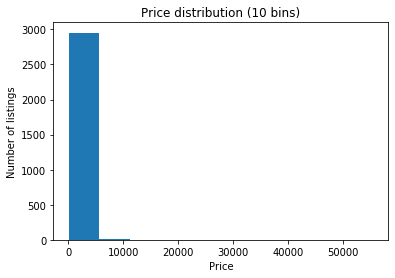

In [25]:
# 1. bin size = 10
plt.hist(price_list,bins=10)
plt.title("Price distribution (10 bins)")
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.show()

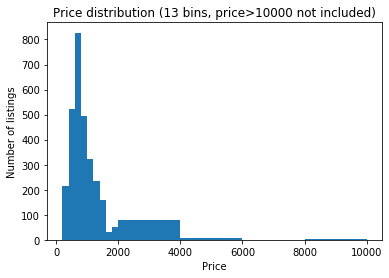

In [26]:
# 2. 13 bins, interval = 200, long tail (price>10000) ignored
plt.hist(price_list,
         bins = [200,400,600,800,1000,1200,1400,1600,1800,2000,4000,6000,8000,10000])
plt.title("Price distribution (13 bins, price>10000 not included)")
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.show()

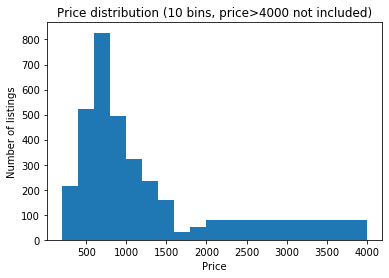

In [27]:
# 3. 10 bins, interval = 200, long tail (price>4000) ignored
plt.hist(price_list,
         bins = [200,400,600,800,1000,1200,1400,1600,1800,2000,4000])
plt.title("Price distribution (10 bins, price>4000 not included)")
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.show()

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [28]:
# cast rating and price column into float, then compute the value of listings and store the results in a new column
copenhagen_value=copenhagen.\
        withColumn('review_scores_rating', f.col('review_scores_rating').cast('float')).\
        withColumn('price', f.regexp_replace('price', '\$', '')).\
        withColumn('price', f.regexp_replace('price', ',', '')).\
        withColumn('price', f.col('price').cast('float')).\
        withColumn('value', f.col('review_scores_rating')/f.col('price'))

In [29]:
# create a window and sort the table by value
value_window = Window.partitionBy('neighbourhood_cleansed').orderBy(f.desc('value'))
ranked_df = copenhagen_value.withColumn('valueRank', f.rank().over(value_window))

In [30]:
# show the top 3 valued listing in each neighbourhood
ranked_df.filter(f.col('valueRank') <= 3).\
    orderBy('neighbourhood_cleansed', f.desc('value')).\
    select('id','neighbourhood_cleansed','value','valueRank').show()

+--------+----------------------+-------------------+---------+
|      id|neighbourhood_cleansed|              value|valueRank|
+--------+----------------------+-------------------+---------+
|27815787|           Amager Vest| 1.3333333333333333|        1|
| 4831559|           Amager Vest|             0.9375|        2|
|12460024|           Amager Vest|0.41841004184100417|        3|
| 5710617|             Amager st| 0.6666666666666666|        1|
|  362647|             Amager st| 0.3861003861003861|        2|
| 3036965|             Amager st|0.38492063492063494|        3|
| 3658168|            Bispebjerg| 0.4311111111111111|        1|
| 7721166|            Bispebjerg|  0.419811320754717|        2|
|35671757|            Bispebjerg|0.37549407114624506|        3|
| 3388899|          Brnshj-Husum| 0.3609022556390977|        1|
| 2836381|          Brnshj-Husum|0.27624309392265195|        2|
| 2956470|          Brnshj-Husum| 0.2672413793103448|        3|
| 2708639|         Frederiksberg|0.31333

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

In [31]:
# join reviews and listings tables on listing id, and keep date and neighbourhood columns
joined=reviews.select('listing_id','date').\
            join(copenhagen.select('id','neighbourhood_cleansed'), 
                 f.col('listing_id') == f.col('id'))

In [32]:
# extract the year, month and date from the date column and store each in a separate column
joined_clean=joined.withColumn('year', f.col('date').substr(1,4)).\
                    withColumn('month', f.col('date').substr(6,2)).\
                    withColumn('day', f.col('date').substr(9,2)).\
                    drop('id')

In [33]:
joined_clean.show()

+----------+----------+----------------------+----+-----+---+
|listing_id|      date|neighbourhood_cleansed|year|month|day|
+----------+----------+----------------------+----+-----+---+
|      6983|2009-09-04|               Nrrebro|2009|   09| 04|
|      6983|2009-09-07|               Nrrebro|2009|   09| 07|
|      6983|2009-09-28|               Nrrebro|2009|   09| 28|
|      6983|2009-12-17|               Nrrebro|2009|   12| 17|
|      6983|2010-01-04|               Nrrebro|2010|   01| 04|
|      6983|2010-04-05|               Nrrebro|2010|   04| 05|
|      6983|2010-05-08|               Nrrebro|2010|   05| 08|
|      6983|2010-06-10|               Nrrebro|2010|   06| 10|
|      6983|2010-06-18|               Nrrebro|2010|   06| 18|
|      6983|2010-06-23|               Nrrebro|2010|   06| 23|
|      6983|2012-04-02|               Nrrebro|2012|   04| 02|
|      6983|2012-04-15|               Nrrebro|2012|   04| 15|
|      6983|2012-04-21|               Nrrebro|2012|   04| 21|
|      6

In [34]:
# craete a cache for faster queries and operations
joined_clean.cache()

DataFrame[listing_id: string, date: string, neighbourhood_cleansed: string, year: string, month: string, day: string]

In [35]:
# count the number of reviews over the years
gb_year=joined_clean.groupBy('year').count().\
                withColumn('year', f.col('year').cast('Integer')).\
                orderBy('year', ascending=True)

In [36]:
gb_year.show()

+----+-----+
|year|count|
+----+-----+
|2009|    4|
|2010|   39|
|2011|  243|
|2012| 1034|
|2013| 3570|
|2014| 8279|
|2015|12817|
|2016|14391|
|2017|13572|
|2018|12929|
|2019|10006|
+----+-----+



In [37]:
# export and visualize
year = [row['year'] for row in gb_year.collect()]
review_count=[row['count'] for row in gb_year.collect()]

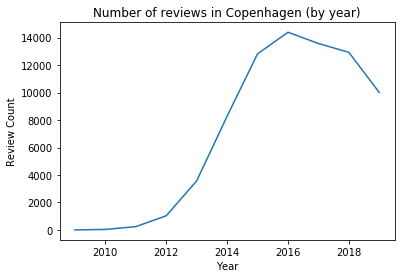

In [38]:
plt.plot(year,review_count)
plt.title("Number of reviews in Copenhagen (by year)")
plt.xlabel("Year")
plt.ylabel("Review Count")
plt.show()

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

In [39]:
# count the number of reviews in each neighbourhood in each year
gb_neighbor_year=joined_clean.groupBy('neighbourhood_cleansed', 'year').count().\
                withColumn('year', f.col('year').cast('Integer')).\
                orderBy(['neighbourhood_cleansed','year'], ascending=[1,1])

In [40]:
gb_neighbor_year.show()

+----------------------+----+-----+
|neighbourhood_cleansed|year|count|
+----------------------+----+-----+
|           Amager Vest|2012|   71|
|           Amager Vest|2013|  341|
|           Amager Vest|2014|  593|
|           Amager Vest|2015|  960|
|           Amager Vest|2016| 1319|
|           Amager Vest|2017| 1160|
|           Amager Vest|2018| 1180|
|           Amager Vest|2019|  917|
|             Amager st|2012|   83|
|             Amager st|2013|  179|
|             Amager st|2014|  574|
|             Amager st|2015|  834|
|             Amager st|2016|  753|
|             Amager st|2017|  760|
|             Amager st|2018|  714|
|             Amager st|2019|  533|
|            Bispebjerg|2012|   11|
|            Bispebjerg|2013|   58|
|            Bispebjerg|2014|  184|
|            Bispebjerg|2015|  360|
+----------------------+----+-----+
only showing top 20 rows



In [41]:
# create a dictionary to store the information, where key is name of the neighbourhood and value is a list of tuples 
# {neighbourhood: [(year1, count1), ...], ...}
dic={}
for row in gb_neighbor_year.collect():
    if row['neighbourhood_cleansed'] in dic:
        dic[row['neighbourhood_cleansed']] += [(row['year'],row['count'])]
    else:
        dic[row['neighbourhood_cleansed']] = [(row['year'],row['count'])]

In [42]:
# plot the number of reviews in each neighbourhood in each year
def plot():    
    fig, ax = plt.subplots(4, 3, figsize=(30,20))
    plt.subplots_adjust(wspace = 0.2, hspace = 0.7)
    
    for index,key in enumerate(dic.keys()):
        row = index//3
        col = index%3      
        ax[row, col].set_title(key)
        ax[row, col].set_xlabel("Year")
        ax[row, col].set_ylabel("Review Count")
        ax[row, col].plot([x[0] for x in dic[key]], [x[1] for x in dic[key]])

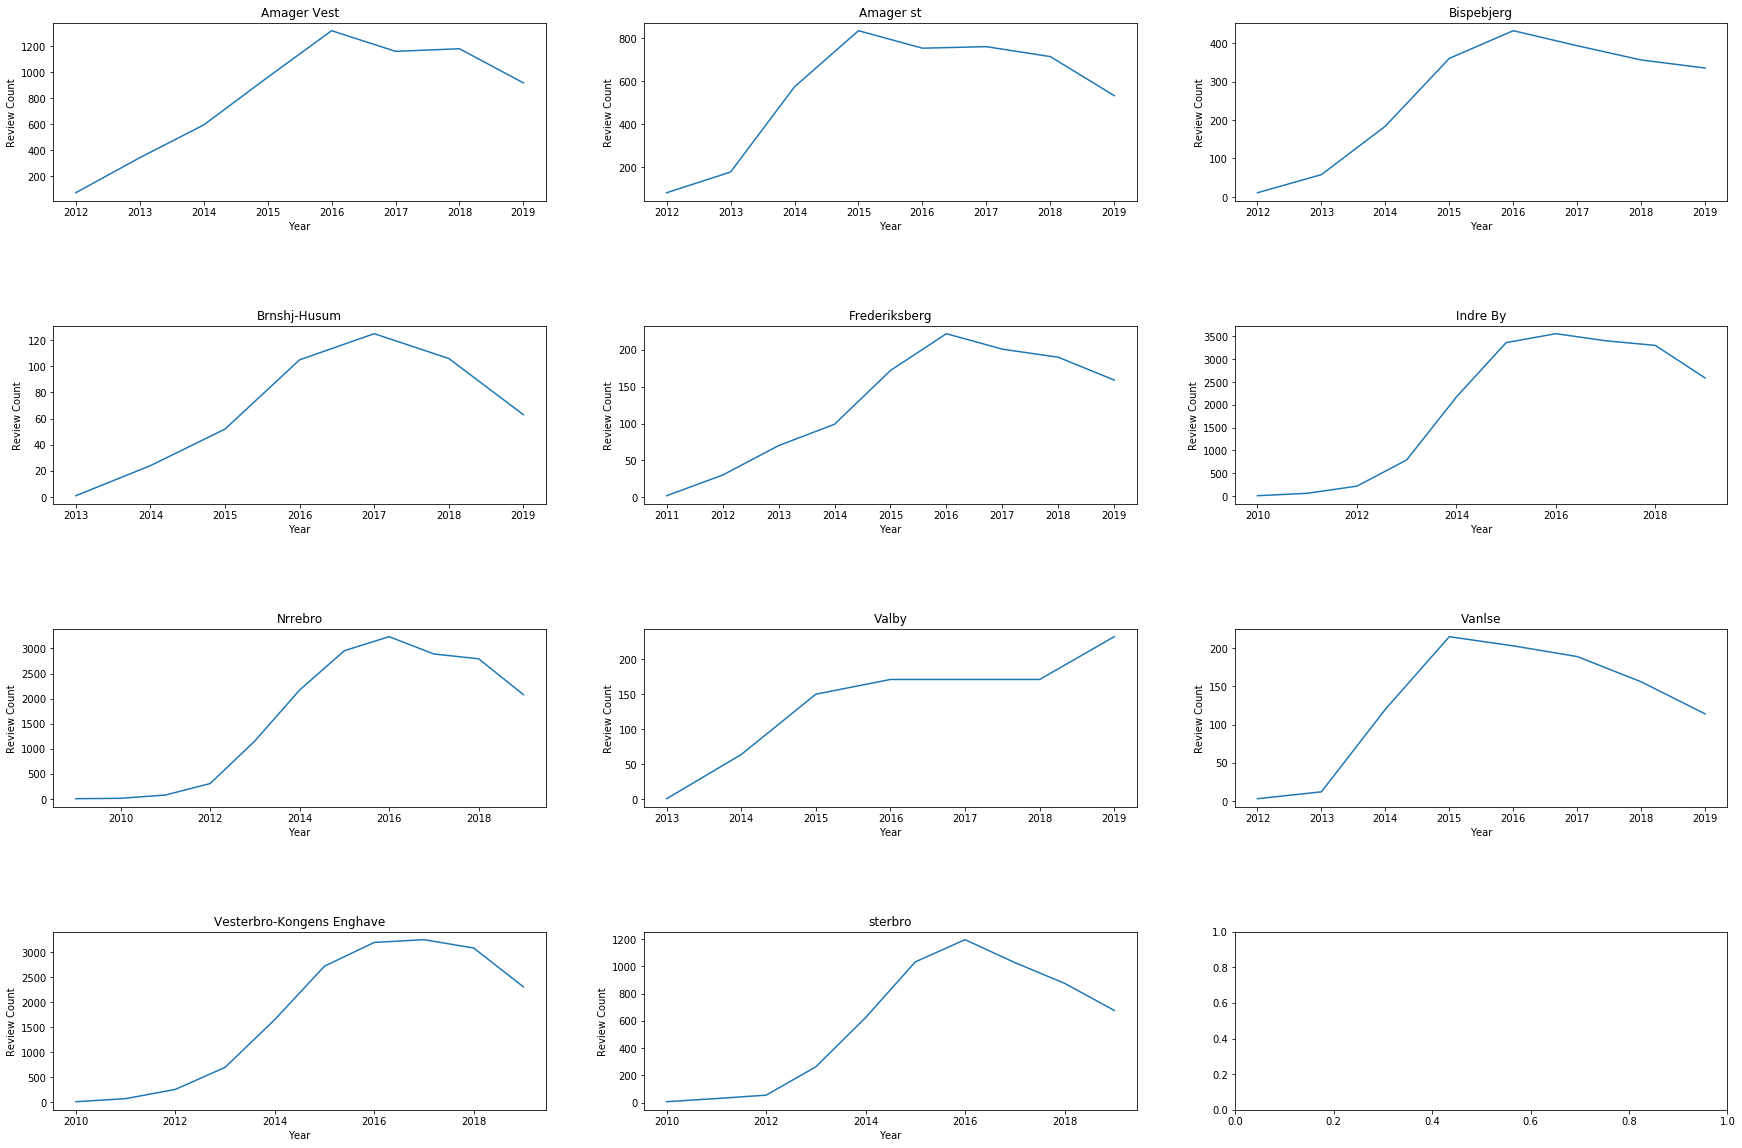

In [43]:
plot()

<font color="navy">Comparing the yearly trends of the reviews, it can be seen that most neighbourhoods experience an upward-then-downward trend, where the number of reviews peaked at 2015-2016 and has been on an decline since then. The only exception is Valby, where the number of reviews increased steadily from 2013 to 2019.</font>

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [44]:
# count the number of reviews by month
gb_month=joined_clean.groupBy('month').count().\
                withColumn('month', f.col('month').cast('Integer')).\
                orderBy('month', ascending=True)

In [45]:
gb_month.show()

+-----+-----+
|month|count|
+-----+-----+
|    1| 3471|
|    2| 3074|
|    3| 3998|
|    4| 5979|
|    5| 9385|
|    6| 9035|
|    7|10139|
|    8|11686|
|    9| 7562|
|   10| 4918|
|   11| 3759|
|   12| 3878|
+-----+-----+



In [46]:
# export and visualize
month = [row['month'] for row in gb_month.collect()]
review_count=[row['count'] for row in gb_month.collect()]

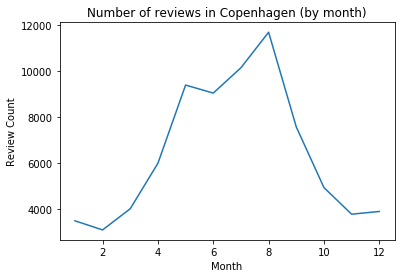

In [47]:
plt.plot(month,review_count)
plt.title("Number of reviews in Copenhagen (by month)")
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.show()

In [48]:
# to see if there is any seasonality effects,
# use groupby to count the number of reviews per month per year
gb_year_month=joined_clean.groupBy('year','month').count().\
                withColumn('year', f.col('year').cast('Integer')).\
                withColumn('month', f.col('month').cast('Integer')).\
                orderBy(['year','month'], ascending=[1,1])

In [49]:
gb_year_month.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2009|    9|    3|
|2009|   12|    1|
|2010|    1|    1|
|2010|    4|    1|
|2010|    5|    1|
|2010|    6|    5|
|2010|    7|    4|
|2010|    8|   12|
|2010|    9|    5|
|2010|   10|    3|
|2010|   11|    4|
|2010|   12|    3|
|2011|    1|    6|
|2011|    2|    4|
|2011|    3|    7|
|2011|    4|   12|
|2011|    5|   15|
|2011|    6|   20|
|2011|    7|   22|
|2011|    8|   48|
+----+-----+-----+
only showing top 20 rows



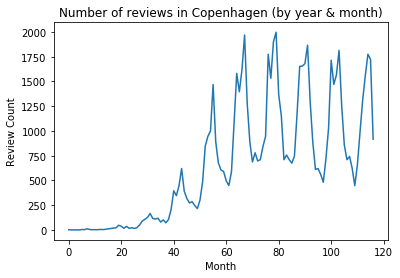

In [50]:
# export and visualize
review_count=[row['count'] for row in gb_year_month.collect()]
plt.title("Number of reviews in Copenhagen (by year & month)")
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.plot(review_count)
plt.show()

<font color="navy">As can be seen from the plot, there is no clear seasonality in the first 40 months, perhaps due to the few number of users as Airbnb was just launched not long ago. Seasonality becomes more pronounced from the 40th month onwards, where a cyclic pattern is observed.

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

<font color="navy">**To fulfil the above requirements, our group has come up with a plan that has the following steps:**

1. join reviews and listings on id, keep the comments and ratings column
<br>
<br>
2. clean and tokenize the comments column
<br>
<br>
3. for each word token, compute its average rating and store this information in a dictionary. This is achieved by:
    1. initializing a dictionary that looks like this: `{token1 : [sum_ratings, total_num_occurrences], ...}`
    2. iterating through every token, and update it accordingly
        - e.g. we start off by having a dictionary {"good": (70, 10)}. This means that so far, the word "good" has a cumulative rating of 70, and this word has occurred for 10 times already. 
        - Should we encounter the word "good" again in a review whose rating is 8, we will update the dictionary accordingly, so that the new dictionary will become {"good":(78, 11)}
    3. finally, computing the average rating of each token by using sum_ratings/total_num_occurrences
        - e.g. in the previous example {"good":(78, 11)}, the average rating of the word "good" will be 78/11 = 7.09
<br>
<br>
4. sort the dictionary and return words with the highest ratings</font>

In [51]:
# Install pip packages gensim in the current Jupyter kernel
# gensim is a Natural Language Processing library
import sys
!{sys.executable} -m pip install gensim

In [52]:
import gensim.parsing.preprocessing as gsp
from gensim import utils
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer

In [53]:
# set up filters for text cleaning
filters = [
           gsp.strip_tags,  # Conversion to lowercase
           gsp.strip_punctuation, # Removal of punctuations
           gsp.strip_multiple_whitespaces, # Removal of extra spaces
           gsp.strip_numeric, # Removal of integers, numbers
           gsp.remove_stopwords, # Removal of stop words (like ‘and’, ‘to’, ‘the’ etc)
           # gsp.stem_text # Stemming (Conversion of words to root form)
          ]

In [54]:
# join reviews and listings tables on listing id, and keep rating and comments columns
pos_table = listings.select('id','review_scores_rating').\
                join(reviews.select('listing_id','comments'), 
                     f.col('id') == f.col('listing_id')).drop('listing_id')

In [55]:
# drop rows where either rating or comments is null
pos_table = pos_table.dropna().cache()

In [56]:
# define a function to preprocess the raw comments
def preprocess_comments(x):
    x = x.lower() # set to lower case
    x = utils.to_unicode(x) # convert to unicode
    for f in filters:
        x = f(x)
    return x

In [57]:
# use pre-process_comments() as a udf
preprocess_comments_udf = f.udf(preprocess_comments)

# <font color="purple">YS's implementation</font>

In [58]:
# sample = pos_table.sample(False, 0.01, 33)

In [59]:
# apply preprocess_comments_udf to the comments column of the spark dataframe
pos_table_processed = pos_table.withColumn('processed_comments', 
                                preprocess_comments_udf(f.col('comments')))

In [60]:
# using Apache Spark to tokenize the words
tokenizer = Tokenizer(inputCol="processed_comments", outputCol="tokens")
pos_table_tokens = tokenizer.transform(pos_table_processed)

In [61]:
# prepare a dictionary that is used for storing and computing the positivity score for each word
ratings_dic = {}

In [62]:
def compute_ratings(row):
    rating = row[1] # rating is the 1st column (0-index based) in the spark dataframe 
    tokens = row[4] # tokens is the 4th column (0-index based) in the spark dataframe
    for token in tokens:
        if token not in ratings_dic:
            ratings_dic[token] = [0,0] # [m, n] where m is the sum of scores & n is the number of occurrences of this token
        ratings_dic[token][0] += int(rating)
        ratings_dic[token][1] += 1

In [63]:
for row in pos_table_tokens.collect():
    compute_ratings(row)

Py4JJavaError: An error occurred while calling o305.collectToPython.
: org.apache.spark.SparkException: Job 38 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:932)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:930)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:78)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:930)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2128)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2041)
	at org.apache.spark.SparkContext$$anonfun$stop$6.apply$mcV$sp(SparkContext.scala:1949)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1340)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1948)
	at org.apache.spark.SparkContext$$anonfun$2.apply$mcV$sp(SparkContext.scala:575)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:216)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:54)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [64]:
import pickle
pickle.dump(ratings_dic, open('rating_dictionary.p', 'wb'))

# <font color="purple">ZY's implementation</font>

In [68]:
# apply preprocess_comments_udf to the comments column of the spark dataframe
pos_table = pos_table.withColumn('processed_comments', preprocess_comments_udf(f.col('comments')))

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65345)
Traceback (most recent call last):
  File "/Users/zq/anaconda3/lib/python3.7/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zq/anaconda3/lib/python3.7/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:65345)

In [66]:
# using Apache Spark to tokenize the words
tokenizer = Tokenizer(inputCol="processed_comments", outputCol="tokens")
pos_table = tokenizer.transform(pos_table)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65345)
Traceback (most recent call last):
  File "/Users/zq/anaconda3/lib/python3.7/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zq/anaconda3/lib/python3.7/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:65345)

In [67]:
pos_table.cache()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65345)
Traceback (most recent call last):
  File "/Users/zq/anaconda3/lib/python3.7/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zq/anaconda3/lib/python3.7/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:65345)

In [ ]:
pos_table.show()

In [ ]:
# extract the scores of each list of tokens into a list
scores_list = pos_table.select("review_scores_rating").rdd.flatMap(lambda x: x).collect()

In [ ]:
# convert ratings in scores_list from string to integer
for index, score in enumerate(scores_list):
    try:
        scores_list[index] = int(score)
        
    # if cannot be converted to integer, change this score to a dummy value -999 
    except:
        scores_list[index] = -999

In [ ]:
import pickle
pickle.dump(scores_list, open('scores_list.p', 'wb'))

In [ ]:
import pickle
with open('scores_list.p', 'rb') as fp:
    scores_list = pickle.load(fp)

In [ ]:
# extract the tokens into a list of lists
tokens_list = pos_table.select("tokens").rdd.flatMap(lambda x: x).collect()

In [ ]:
# prepare a dictionary that is used for storing and computing the positivity score for each word
ratings_dic = {}

In [ ]:
# iterate through the tokens and build a dictionary that stores each token's sum of scores and its number of occurrences
for index, tokens in enumerate(tokens_list):
    score = scores_list[index]
    if score == -999: # bad entries
        continue # ignore this record and proceed with the next
    for token in tokens:
        if token not in ratings_dic:
            ratings_dic[token] = [0,0] # [m, n] where m is the sum of scores & n is the number of occurrences of this token
        ratings_dic[token][0] += score # increment the total scores of this token by 1
        ratings_dic[token][1] += 1 # increment the occurrences of this token by 1

In [ ]:
# ratings_dic

In [ ]:
# prepare a dictionary that is used for storing the average rating for each word
ave_ratings_dic = {}

# iterate through the key-value pairs in ratings_dic and build a dictionary that stores each token's average rating
for key, value in ratings_dic.items():
    
    # filter the dictionary and remove words that occur below a certain number of times
    threshold = 500 # remove words that occur fewer than 500 times across all reviews
    if value[1] < threshold: 
        continue
    
    ave_rating = value[0]/value[1]
    ave_ratings_dic[key] = ave_rating

In [ ]:
# sort the dictionary based on each token's average rating in descending order
# output a list of tuples, with the first element of each tuple being the token, and the second being its average score
sorted_ave_ratings = sorted(ave_ratings_dic.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# enquire the top 100 most positive words in the reviews
sorted_ave_ratings[:100]

1. select id and rating from listings
2. select id and comment from reviews
3. join two on id
4. define user defined function udf e.g.
5. use udf to clean comment column --> remove stop words, common words blah blah, stemming maybe? stemming may be too computationally expensive, we could omit.

6. store in a dic, key == rating , value == comment. if same rating, just concat comments. after iterations, value should be very long (few comments concat)

7. tokenize comment, assign rate to each token and store avg rating for each word in a new dic. Lets say original dic is {7 : "it is good", 8: "it looks good and fantastic"}, the new dic will be {'good' : (7+8)/2 = 7.5, "fantastic" : 8}
    - <font color="red">searching through each word in the original dic ({7 : "it is good", 8: "it looks good and fantastic"}) and computing its ave rating might be computationally expensive(?). I'm thinking if we can obtain the new dic ({'good' : (7+8)/2 = 7.5, "fantastic" : 8}) directly from the raw text. 
    - So basically we tokenize a review first, and for every token that is an adjective (see my comment in the next code cell under bullet point #2), append it to a dictionary with its appropriate score and occurrence. e.g. we have a dictionary that is {"good": (70, 10)}, meaning that so far, the word "good" has a cumulative rating of 70, and this word has occurred for 10 times already. If we encounter the word "good" again in a review whose rating is 8, we will update the dictionary accordingly, so that the new dictionary will become {"good":(78, 11)}. Lookup is O(1) and from this dictionary, we can output the final positivity score of a word directly simply by using 78/11. What do you think?</font>
<br>
<br>
8. return the highest score words

a few concerns:
1. too many words invloved, i am not sure if a dic is appropriate, maybe should use streaming sketch, i do not know..
    - <font color="red">agreed. anyway preprocessing needs to be done in Spark so no choice</font>
2. only considered listing rating in positivity weight. "For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review." maybe consider others, keep a counter on how many times this word appears, below a threshold then drop. This may help with point 1.
    - <font color="red">im not sure if this is what you mean, but to me it sounds a bit like the TF part of tfidf right? To help reduce the memory and also increase the accuracy, I'm thinking of only retaining the adjectives in each review, as they are the ones that will give insight into how positive the listing is. I've done 词性分析 on Chinese text using jieba, pretty sure there are libraries out there that perform similar tasks on English text too. Will do a bit of research on this part later on.</font>
3. yes, memory space is a concern...can we store so many words in memory?